In [1]:
%matplotlib inline

import os
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, Input, Activation, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Convolution3D, MaxPooling3D, GlobalAveragePooling3D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils.vis_utils import model_to_dot

In [2]:
from google.colab import drive
drive.mount('./gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./gdrive


In [3]:
%cd "gdrive/My Drive/Colab Notebooks/data"

/content/gdrive/My Drive/Colab Notebooks/data


In [2]:
def Shortcut3D(input_data, fx, data_format = "channels_first"):

  # チャンネル数の取得
  if data_format == "channels_first":
    channel_num = int(fx.shape[1])
  else:
    channel_num = int(fx.shape[4])
      
  # inputs と residual とでチャネル数が違うかもしれない。
  # そのままだと足せないので、1x1 conv を使って residual 側のフィルタ数に合わせている
  buf = Convolution3D(channel_num, (1,1,1), strides=(1,1,1), padding='valid', data_format=data_format)(input_data)

  # 2つを足す
  return Add()([buf, fx])

In [3]:
def Resblock3D(n_filters, strides=(1,1,1), data_format = "channels_first", axis=1):
  def f(input_data):   
    fx = Convolution3D(n_filters, (3,3,3), strides=strides, kernel_initializer='he_normal', padding='same', data_format=data_format)(input_data)
    fx = BatchNormalization(axis=axis)(fx)
    fx = Activation('relu')(fx)
    fx = Convolution3D(n_filters, (3,3,3), strides=strides, kernel_initializer='he_normal', padding='same', data_format=data_format)(fx)
    fx = BatchNormalization(axis=axis)(fx)

    return Shortcut3D(input_data, fx, data_format)

  return f

In [4]:
def Resnet3D(channel = 3, frame = 10, height = 64, width = 64, num_classes = 2, is_channels_first = True):
  if is_channels_first:
    data_format = "channels_first"
    axis=1
    input_data = Input(shape=(channel, frame, height, width))
  else:
    data_format = "channels_last"
    axis=-1
    input_data = Input(shape=(frame, height, width, channel))
  
  print(input_data.shape)

  x = Convolution3D(32, (7,7,7), strides=(1,1,1), kernel_initializer='he_normal', padding='same', data_format=data_format)(input_data)
  x = BatchNormalization(axis=axis)(x)
  x = Activation('relu')(x)
  x = MaxPooling3D((3, 3,3), strides=(2,2,2), padding='same', data_format=data_format)(x)


  x = Resblock3D(n_filters=64, data_format = data_format, axis=axis)(x)
  x = Resblock3D(n_filters=64, data_format = data_format, axis=axis)(x)
  x = Resblock3D(n_filters=64, data_format = data_format, axis=axis)(x)
  x = MaxPooling3D(strides=(2,2,2), data_format=data_format)(x)  
  x = Resblock3D(n_filters=128, data_format = data_format, axis=axis)(x)
  x = Resblock3D(n_filters=128, data_format = data_format, axis=axis)(x)
  x = Resblock3D(n_filters=128, data_format = data_format, axis=axis)(x)


  x =  GlobalAveragePooling3D(data_format=data_format)(x)
  x = Dense(num_classes, kernel_initializer='he_normal', activation='softmax')(x)

  model = Model(inputs=input_data, outputs=x)
  return model

In [5]:
is_channels_first = True

if is_channels_first:
  print("A")
  buf = np.load('./resnet3d_data_channel_first_updown_and_wipe_frame-3_100x100_20191012.npz')


else:
  print("B")
  buf = np.load('./resnet3d_data_channel_last_updown_and_wipe_frame-3_100x100_20191012.npz')

X = buf["X"].astype("f2")
Y = buf["Y"]
del buf

Y = keras.utils.to_categorical(Y, 2, dtype="f2").astype("f2")
X_train, X_val,  Y_train,  Y_val = train_test_split(X, Y, train_size=0.8, shuffle=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, train_size=0.8, shuffle=True)

A


In [9]:
X_val.shape

(812, 3, 3, 100, 100)

In [0]:
def step_decay(epoch):
    x = 0.001
    if epoch >= 2: x /= 5.0
    if epoch >= 4: x /= 5.0
    if epoch >= 6: x /= 5.0
    return x
  
decay = LearningRateScheduler(step_decay, verbose=1)

In [6]:
model = Resnet3D(channel=3, frame=3, height=100, width=100, num_classes=2, is_channels_first=is_channels_first)
adam = keras.optimizers.Adam(lr=0.00001)
#lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.0001 + 0.02 * np.math.pow(0.5, 1+epoch), verbose=True)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath=os.path.join("./", 'ResNet34-3D_GPU_adam-decay_epoch-{epoch:02d}_valloss-{val_loss:.2f}.hdf5'), save_best_only=True)

(None, 3, 3, 100, 100)


In [0]:
is_tpu = False

if is_tpu:
  # TPU
  tpu_grpc_url = "grpc://"+os.environ["COLAB_TPU_ADDR"]
  tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
  strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu_cluster_resolver)
  model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

In [0]:
model.load_weights("ResNet34-3D_GPU_epoch-05_valloss-0.00.hdf5")

In [7]:
import sys

In [9]:
sys.getsizeof(X_train) / 1024 / 1024

445.9764099121094

In [14]:
history = model.fit(X_train, Y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    # callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1)],
                    callbacks=[checkpoint],
                    validation_data=(X_test, Y_test))

Train on 2598 samples, validate on 650 samples
Epoch 1/100
2598/2598 [==============================] - 105s 40ms/sample - loss: 0.2703 - accuracy: 0.8714 - val_loss: 2.2602 - val_accuracy: 0.5138
Epoch 2/100
2598/2598 [==============================] - 98s 38ms/sample - loss: 0.0762 - accuracy: 0.9869 - val_loss: 1.3867 - val_accuracy: 0.5138
Epoch 3/100
2598/2598 [==============================] - 98s 38ms/sample - loss: 0.0335 - accuracy: 0.9996 - val_loss: 1.1890 - val_accuracy: 0.5138
Epoch 4/100
2598/2598 [==============================] - 98s 38ms/sample - loss: 0.0160 - accuracy: 1.0000 - val_loss: 1.4973 - val_accuracy: 0.5138
Epoch 5/100
2598/2598 [==============================] - 98s 38ms/sample - loss: 0.0114 - accuracy: 1.0000 - val_loss: 1.9387 - val_accuracy: 0.5138
Epoch 6/100
2598/2598 [==============================] - 98s 38ms/sample - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.9644 - val_accuracy: 0.5200
Epoch 7/100
2598/2598 [==============================] - 9

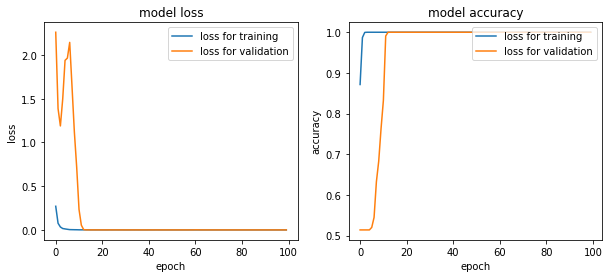

In [15]:
fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
def plot_history_loss(fit, fig, axL, axR):
    # Plot the loss in the history
    axL.plot(fit.history['loss'],label="loss for training")
    axL.plot(fit.history['val_loss'],label="loss for validation")
    axL.set_title('model loss')
    axL.set_xlabel('epoch')
    axL.set_ylabel('loss')
    axL.legend(loc='upper right')

# acc
def plot_history_acc(fit, fig, axL, axR):
    # Plot the loss in the history
    axR.plot(fit.history['accuracy'],label="loss for training")
    axR.plot(fit.history['val_accuracy'],label="loss for validation")
    axR.set_title('model accuracy')
    axR.set_xlabel('epoch')
    axR.set_ylabel('accuracy')
    axR.legend(loc='upper right')
    
plot_history_loss(history, fig, axL, axR)
plot_history_acc(history, fig, axL, axR)

In [16]:
score = model.evaluate(X_val[:4, : , :, :, :], Y_val[:4,:],
                    verbose=0
                    )

print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 8.195640077701682e-08
Test accuracy: 1.0


In [25]:
X_test[:4,:,:,:, :]

array([[[[[0.4158  , 0.3215  , 0.3452  ],
          [0.3765  , 0.3215  , 0.3293  ],
          [0.2783  , 0.255   , 0.2825  ],
          ...,
          [0.4119  , 0.4038  , 0.451   ],
          [0.5923  , 0.5806  , 0.639   ],
          [0.6     , 0.5923  , 0.6235  ]],

         [[0.4     , 0.3254  , 0.341   ],
          [0.3882  , 0.349   , 0.353   ],
          [0.2825  , 0.251   , 0.2825  ],
          ...,
          [0.4119  , 0.4038  , 0.451   ],
          [0.612   , 0.6     , 0.6587  ],
          [0.6     , 0.5923  , 0.6235  ]],

         [[0.4     , 0.3452  , 0.353   ],
          [0.3647  , 0.3452  , 0.353   ],
          [0.2825  , 0.251   , 0.2825  ],
          ...,
          [0.4119  , 0.4038  , 0.451   ],
          [0.6196  , 0.608   , 0.6665  ],
          [0.6     , 0.5923  , 0.6235  ]],

         ...,

         [[0.01569 , 0.      , 0.00784 ],
          [0.02353 , 0.      , 0.01569 ],
          [0.0353  , 0.      , 0.02745 ],
          ...,
          [0.718   , 0.71    , 0.6943

In [ ]:
model.save('model_fram3_100x100_ncdhw.h5', include_optimizer=False)